# Chapter 2: More Image Manipulation

### Implementing Color Pop Effects

In [79]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from PIL import Image, ImageFont, ImageDraw, ImageFilter, ImageOps
from PIL.ImageChops import add, subtract, multiply, difference, screen, soft_light, hard_light, overlay, lighter
import PIL.ImageStat as stat
from pillow_lut import load_cube_file
from skimage import color, exposure, img_as_float, data
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
from skimage.transform import SimilarityTransform, PiecewiseAffineTransform, warp, swirl, rescale, resize, downscale_local_mean
from skimage.util import view_as_blocks, invert, random_noise, montage
from skimage.color import rgb2gray, gray2rgb
from skimage import measure
import scipy.ndimage as ndimage
from scipy.ndimage import affine_transform
import cv2
import wand
import blend_modes #, imgviz
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pylab as plt
from time import time
import os

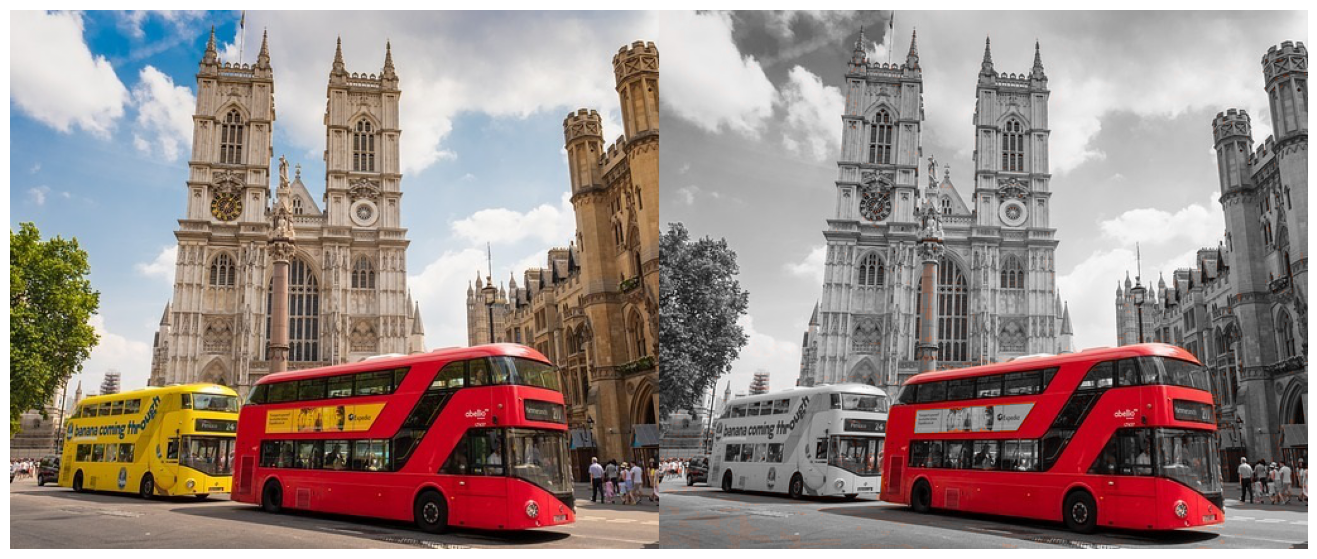

In [10]:
def apply_color_pop(im):
    gray = rgb2gray(im)
    gray = np.stack((gray,)*3, axis=-1)
    hsv = color.rgb2hsv(im)
    mask_cond = (hsv[...,0] <= 10/180) | ((hsv[...,0] >= 170/180))
    gray[mask_cond] = im[mask_cond]    
    return gray

# Load an image and apply the color pop effect
im = imread('images/bus.jpg')
im = im/im.max()
out_im = apply_color_pop(im)

plt.figure(figsize=(20,7))
plt.imshow(np.hstack((im, out_im))), plt.axis('off')
plt.show()

## Correcting a Fish-eye distorted Image

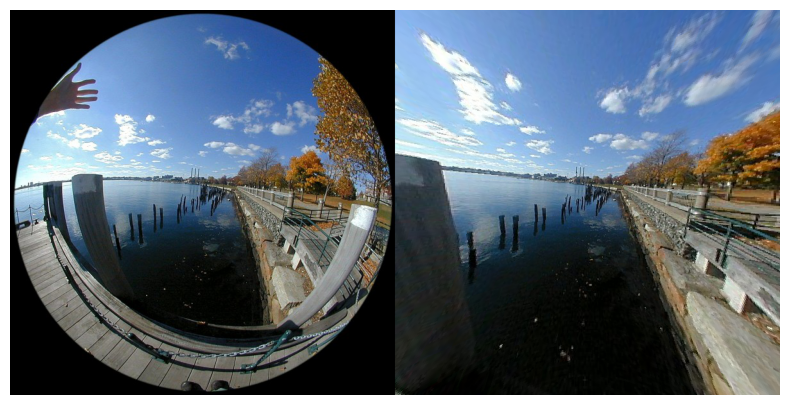

In [15]:
def undistort(im, zoom = 1):
    w, h = im.shape[:2]
    im_new = np.zeros_like(im)
    hw, hh = w / 2, h / 2
    strength = 5 #0.00001
    correction_radius = np.sqrt(w ** 2 + h ** 2) / strength
    for x in range(w):
        for y in range(h):
            new_x, new_y = x - hw, y - hh
            distance = np.sqrt(new_x**2 + new_y**2)
            r = distance / correction_radius
            theta = 1 if r == 0 else np.arctan(r) / r
            source_x, source_y = hw + theta * new_x * zoom, hh + theta * new_y * zoom
            #set color of pixel (x, y) to color of source image pixel at (source_x, source_y)
            im_new[x, y] = im[round(source_x), round(source_y)]
    return im_new
        
distorted_image = imread('images/distorted.jpg')
undistorted_image = undistort(distorted_image)
# plot the images here
plt.figure(figsize=(12,5))
plt.imshow(np.hstack((distorted_image, undistorted_image))), plt.axis('off')
plt.show()

As can be seen from the above figure, the `undistort()` function removes the fisheye distortion from the input image to a great extent.

## Image Manipulations with `scikit-image`

As done above using the library `PIL`, we can also use the `scikit-image` library functions for
image manipulation, some examples are shown below.


### Inverse warping and Geometric transformation using the `warp ()` function
`scikit-image` `transform` module's `warp()` function can be used for inverse warping for geometric
transformation of an image (discussed in a previous section), as demonstrated in the
following examples.

#### Applying translation on an image

For all possible pixels in translated output image $(x,y)$, the corresponding points in the
input image $(u, v)$ can be found with the following equations:

$$ u=x-t_x $$
$$ v=y-t_y $$

where $t_x$ and $t_y$ demotes translations along x and y axis, respectively (and $x(u,v) = x$,
$y(u,v)=y$). The following code block shows how to use the `warp()` function to translate an
image. 

In [18]:
def translate(xy, t_x, t_y):
    xy[:, 0] -= t_y
    xy[:, 1] -= t_x
    return xy

im = imread('images/monalisa.jpg')
im_trans = warp(im, translate, map_args={'t_x':50, 't_y':-100}) # create a dictionary for translation parameters

#### Applying rotation to an image

If an image is rotated by angle $\theta$ counterclockwise, for all possible pixels in rotated output image $(x,y)$, the corresponding points in the input image $(u, v)$ can be found with the following equations:

$$ u=x.cos \theta -y.sin \theta $$
$$ v=x.sin \theta +y.cos \theta $$

The following code block shows how to use the `warp()` function to rotate an image. 

In [19]:
def rotate(xy, theta):
    theta = np.pi/180*theta
    xy[:, 0], xy[:, 1] = xy[:, 0]*np.cos(theta) - xy[:,1]*np.sin(theta), xy[:, 0]*np.sin(theta) + xy[:,1]*np.cos(theta)
    return xy

im_rot = warp(im, rotate, map_args={'theta':10}) # create a dictionary for rotation parameters

#### Applying an Affine transformation to an image

We can use the function `SimilarityTransform()` to compute the transformation matrix,
followed by `warp()` function, to carry out the transformation, as shown in the next code
block. 

In [20]:
tform = SimilarityTransform(scale=0.9, rotation=np.pi/4,translation=(im.shape[0]/2, -100))
im_sim = warp(im, tform)

### Applying the Swirl transform

This is a non-linear transform and defined by the documentation as follows.
The swirl transformation Consider the coordinate $(x,y)$ in the output image. The reverse mapping for the swirl
transformation first computes, relative to a center ($x_0,y_0$), its polar coordinates $\rho, \theta$, and then transforms them according to the following:

![](images/swirl.png)

where strength is a parameter for the amount of swirl, radius indicates the swirl extent in
pixels, and rotation adds a rotation angle. The transformation of radius into $r$ is to ensure
that the transformation decays to $≈1/1000^{th}$ within the specified radius. Here we shall use the `swirl()` function from the `skimage.transform` module.

The next figure shows the output images by applyting different tranforms using the above code snippet, the input parrot image.

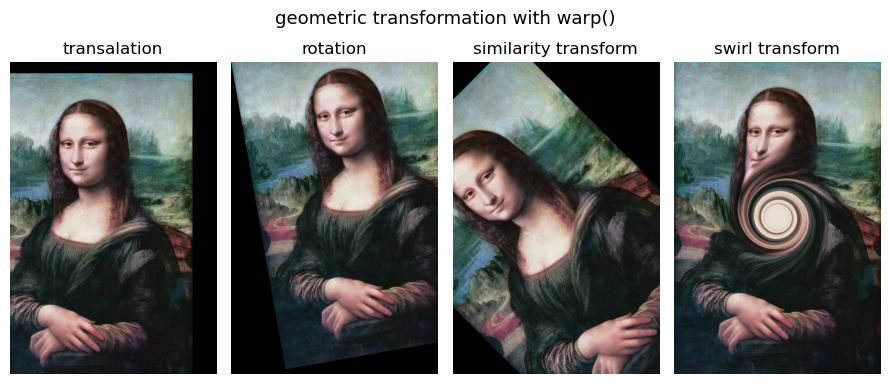

In [29]:
im_swirled = swirl(im, rotation=0, strength=60, radius=300)

plt.figure(figsize=(9,4))
plt.subplot(141), plt.imshow(im_trans), plt.axis('off'), plt.title('transalation', size=12)
plt.subplot(142), plt.imshow(im_rot), plt.axis('off'), plt.title('rotation', size=12)
plt.subplot(143), plt.imshow(im_sim), plt.axis('off'), plt.title('similarity transform', size=12)
plt.subplot(144), plt.imshow(im_swirled), plt.axis('off'), plt.title('swirl transform', size=12)
plt.suptitle('geometric transformation with warp()', size=13)
plt.tight_layout()
plt.show()

### Applying Piecewise Affine Transformation

A piecewise affine transformation is a type of geometric transformation that divides an image into smaller regions and applies an affine transformation independently to each region. This allows for more flexible and localized transformations compared to a global affine transformation.

In `scikit-image`, you can use the `PiecewiseAffineTransform` class to implement piecewise affine transformations. Here's a step-by-step guide on how to do it:

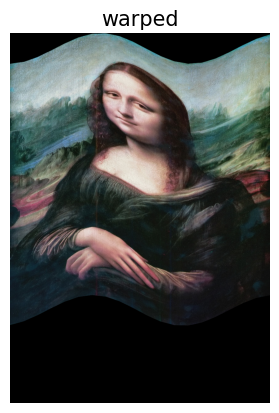

In [30]:
rows, cols = im.shape[0], im.shape[1]

src_cols = np.linspace(0, cols, 20)
src_rows = np.linspace(0, rows, 10)
src_rows, src_cols = np.meshgrid(src_rows, src_cols)
src = np.dstack([src_cols.flat, src_rows.flat])[0]

# add sinusoidal oscillation to row coordinates
dst_rows = src[:, 1] - np.cos(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
dst_cols = src[:, 0]
dst_rows *= 1.5
dst_rows -= 1.5 * 50
dst = np.vstack([dst_cols, dst_rows]).T

tform = PiecewiseAffineTransform()
tform.estimate(src, dst)

out_rows = im.shape[0] - 1.5 * 50
out_cols = cols
out = warp(im, tform, output_shape=(out_rows, out_cols))

plt.imshow(out), plt.axis('off')
plt.title('warped', size=15)
plt.show()

### Adding Random Gaussian Noise to images

We can use the `random_noise()` function to add different types of noise to an image. The next
code example shows how Gaussian noise with different variances can be added to an image. The next figure shows the output image generated by adding Gaussian noises with
different variance, by running the below code snippet. As can be seen, the more the
standard deviation of the Gaussian noise, the noisier becomes the output image.

In [ ]:
im = img_as_float(imread("images/parrot.png"))
plt.figure(figsize=(12,10))
sigmas = [0.1, 0.25, 0.5, 1]
for i in range(4):
    noisy = random_noise(im, var=sigmas[i]**2)
    plt.subplot(2,2,i+1), plt.imshow(noisy), plt.axis('off')
    plt.title('Gaussian noise with sigma=' + str(sigmas[i]), size=20)
plt.tight_layout()
plt.show()

### Creating a montage of several multi-channel images

The next code example shows how the function `montage()` can be used to create a montage
of noisy images obtained by using Gaussian noise with different variances to an image.

In [ ]:
im = img_as_float(imread("images/parrot.png"))
plt.figure(figsize=(12,12))

sigmas = np.linspace(0, 1, 16)
noisy_images = np.zeros((25, im.shape[0], im.shape[1], im.shape[2]))
for i in range(len(sigmas)):
    noisy_images[i,:,:,:] = random_noise(im, var=sigmas[i]**2)
    noisy_images_montage = montage(noisy_images, rescale_intensity=True, multichannel=True)
plt.imshow(noisy_images_montage), plt.axis('off')
plt.tight_layout()
plt.show()

### Computing the Cumulative Distribution function of an image

We can compute the cumulative distribution function (cdf) for a given image with
the `cumulative_distribution()` function, as shown below. The next figure plots the cumulative distributions for each of the R,G,B channels, as an output of the next code snippet.

In [ ]:
im = imread("images/parrot.png")
cdf_r = exposure.cumulative_distribution(im[:,:,0]) # cdf for the red channel
cdf_g = exposure.cumulative_distribution(im[:,:,1]) # cdf for the green channel
cdf_b = exposure.cumulative_distribution(im[:,:,2]) # cdf for the blue channel
plt.figure(figsize=(8,6))
plt.plot(cdf_r[1], cdf_r[0], 'r.-')
plt.plot(cdf_g[1], cdf_g[0], 'g.-')
plt.plot(cdf_b[1], cdf_b[0], 'b.-')
plt.xlabel('pixel value (x)', size=15)
plt.ylabel('cumulate propability P(X <= x)', size=15)
plt.show()

### Resizing / rescaling an image

In [ ]:
image = imread('images/model.png')[...,:3]
image = image / image.max()

image_rescaled = rescale(image, 0.25, anti_aliasing=False, channel_axis=-1)
image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True)
image_downscaled = downscale_local_mean(image, (4, 3, 1))
print(image.shape, image_rescaled.shape, image_resized.shape, image_downscaled.shape)

plt.figure(figsize=(10,5))
plt.gray()
plt.imshow(np.hstack((image_rescaled, image_resized, image_downscaled))), plt.axis('off')
plt.title('rescaled (aliasing), resized (no aliasing) and downnscaled images', size=10)
plt.show()

In [47]:
def plot_image(im, title='', fontsize=20):
     plt.imshow(im), plt.axis('off'), plt.title(title, size=fontsize)

def plot_images(images, titles, suptitle='', fontsize=20, \
                                supfontsize=22, figsize=(15,7)):
    n = len(images)
    plt.figure(figsize=figsize)
    plt.gray()
    for i in range(n):
        plt.subplot(1,n,i+1), plot_image(images[i], titles[i], fontsize)
    plt.suptitle(suptitle, size=supfontsize)
    plt.tight_layout()
    plt.show() 

(1280, 846, 3) (55, 216, 3)


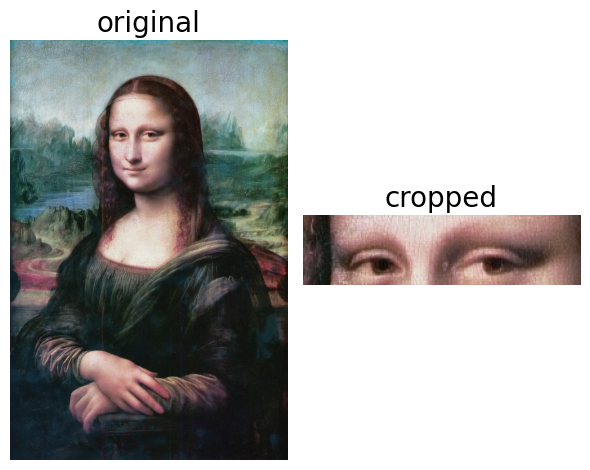

In [62]:
from skimage.util import crop 
 
im = imread('images/monalisa.jpg') 
im_cropped = crop(im, ((250, 975), (280, 350), (0,0)), copy=False) 
print(im.shape, im_cropped.shape) 
# (1280, 846, 3) (30, 171, 3) 
plot_images([im, im_cropped], ['original', 'cropped'], figsize=(6,5)) 

#### Inverting an image

We can use simply the `invert()` function to get the negative of an image, as shown in the
code below. The next figure shows the output negative image generated by running the next line of
code.

In [ ]:
im = im / im.max()
np.all(1 - im == invert(im))
Image.fromarray((255*(1-im)).astype(np.uint8))

In [ ]:
import cv2
im = cv2.cvtColor(cv2.imread('images/parrot.png'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,7))
plt.imshow(np.hstack((im,
            # Flip Image Vertically
            cv2.flip(im, flipCode=0),
            # Flip Image Horizontally
            cv2.flip(im, flipCode=1),
            # Flip Image Vertically and Horizontally
            cv2.flip(im, flipCode=-1))))
plt.show()

## Image Manipulations with `PIL` / `Pillow`

`PIL` provides us with many functions to manipulated an image, e.g., using a point
transformation to change the pixel values or to perform geometric transformations on an
image. Let us first start by loading the parrot png image, as shown in the following code. The next few sections describe how to do different types of image manipulations with `PIL`.

In [552]:
im = Image.open("images/parrot.png") # open the image, provide the correct path
print(im.width, im.height, im.mode, im.getbands(), im.format) # print image size, mode and format

453 340 RGB ('R', 'G', 'B') PNG


In [554]:
x = im.load()
x[0,0]

(81, 116, 94)

In [555]:
print(im.getdata()[0])
print(im.convert('L').getdata()[0])
print(im.convert('F').getdata()[0])

(81, 116, 94)
103
103.0270004272461


In [545]:
im_data = im.getdata()
print(type(im_data)) 
print(im_data.size) 
print(im.convert('L').getdata().getextrema())

<class 'ImagingCore'>
(225, 225)
(1, 235)


## Cropping an image

We can use the `crop()` function with the desired rectangle argument to extract the
corresponding area from the image, as shown in the following code.

In [16]:
im = Image.open("images/parrot.png")
im_c = im.crop((175,75,320,200)) # crop the rectangle given by (left, top, right, bottom) from the image
im_c.save("images/parrot_cropped.jpg")
im_c.show()

The next figure displays the image saved in jpg format using the above code.

In [ ]:
im_c

## Resizing an image

In order to increase or decrease the size of an image we can use the resize() function that
internally up-samples or down-samples the image, respectively.

### Resizing to a larger image

Let us start with a small clock image of size 149 x 97 and create a larger size image. The next
code snippet shows the small clock image to start from.

In [72]:
im = Image.open("images/bricks_small.jpeg")
print(im.width, im.height)
# 107 105
im.show()

150 100


The next line of code shows how the `resize()` function can be used to enlarge the above input clock image (by
a factor of 5) to obtain an output image of size 25 times larger than the input image, using bi-linear
interpolation (an up-sampling technique), the details about how this technique works will be described in the
second chapter.

In [ ]:
im = Image.open("images/bricks_small.jpeg") 
print(im.width, im.height) 
# 150 100 
im.resize((im.width*5, im.height*5), Image.BILINEAR) \
                                 .save('images/bricks_large.jpeg')  
im_large = Image.open("images/bricks_large.jpeg") 
print(im_large.width, im_large.height) 
# 750 500 
im_concat = Image.new('RGB', (2*im_large.width, im_large.height)) 
im_concat.paste(im, (0,0)) 
im_concat.paste(im_large, (im_large.width,0)) 
im_concat #.show() 

### Resizing to a smaller image

Now let us do the reverse, i.e. start with a large image of the Victoria Memorial Hall (of size
720 x 540) and create a smaller-sized image. The next code snippet shows the large image to
start from.

In [ ]:
im = Image.open("images/victoria_memorial.png") 
im.resize((im.width//5, im.height//5), Image.Resampling.LANCZOS).save('images/victoria_memorial_small.png')  
im_small = Image.open("images/victoria_memorial_small.png") 
im_concat = Image.new('RGB', (2*im.width, im.height)) 
im_concat.paste(im, (0,0)) 
im_concat.paste(im_small, (im.width,0)) 
im_concat #.show() 

The next line of code shows how the function `resize()` can be used to shrink the above image
of the Victoria Memorial Hall (by a factor of 5) to resize it to an output image of size 25
times smaller than the input image, using anti-aliasing (a high-quality down-sampling
technique), the details how it works will be described in the second chapter.

### Pixelating an image

Pixelation refers to the visual effect of making an image appear blurry or unclear by replacing fine details with larger, square-shaped blocks or pixels. This technique is often used to obscure or hide sensitive information, such as faces or other identifying features, in images or videos. Pixelation is a form of image processing that reduces the level of detail in a specific region of an image.

The process of pixelation involves dividing the image into small, discrete square areas and replacing the pixel values within those areas with an average or representative color. This results in a blocky appearance that makes it difficult to discern the finer details of the original image. The extent of pixelation, or the size of the pixel blocks used, can be adjusted to achieve varying levels of obscuration.

Here's a basic overview of how pixelation is done:

* Determine the Region to Pixelate
* Define Pixel Block Size
* Replace Pixel Values
* Apply the Pixelation Effect

Let's first implement the function `pixelate()`, as shown in the next image, it applies pixelation to the entire input image 

* first by reducing the size of the image by the given input `factor` using **Bilinear interpolation** and
* then resizing the image using **Nearest neigbor interpolation**.

The next code snippet shows how the pixelation effect is applied to the input parrot image, with different values of `factor` (e.g., 16 and 32).

In [ ]:
def pixelate(im, factor):
    # Resize down smoothly
    im_small = im.resize((im.width//factor, im.height//factor), resample=Image.BILINEAR)
    # Scale back up using NEAREST to original size
    return im_small.resize(im.size, Image.NEAREST)

im = Image.open("images/parrot.png")
plt.figure(figsize=(15,6))
plt.imshow(np.hstack([np.array(im)] + [np.array(pixelate(im, factor)) for factor in [16,32]])), plt.axis('off')
plt.title('Pixelating by downsampling to factor of 16 and 32', size=20)
plt.show()

### Pixelating a region (face) of an image

Now, let's apply the pixelation to a part of the image, for example, the face region in the input lena image, where we want to hide the details. The pixelation effect can be applied to the refion of interest (ROI) using `numpy` slicing, as shown in the next code snippet and shown in the following figure.

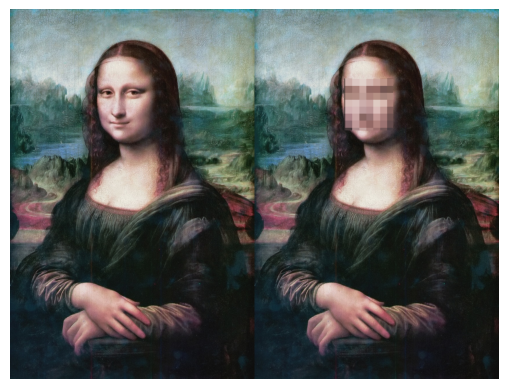

In [122]:
im = Image.open("images/monalisa.jpg")
im_p = pixelate(im, 24)
x, y, h, w = 310, 240, 180, 170 #105, 105, 55, 45  # specify rect region
out = np.array(im)
out[y:y+h, x:x+w] = np.array(im_p)[y:y+h, x:x+w]
plt.imshow(np.hstack((np.array(im), out))), plt.axis('off')
plt.show()

###  Inverting, Solarizing and Posterizing an Image

We can use the `point()` function from `PIL.Image` to transform each pixel value with a single-argument
function. We can use it to negate an image as shown in the next code block. The pixel
values are represented using 1-byte unsigned integers, that is why subtracting it from the
maximum possible value will be the exact point operation required on each pixel to get the
inverted image.

### Inverting / Negating an image

Inverting or negating an image involves reversing the colors of the pixels, turning light areas dark and vice versa. The inversion is typically performed by subtracting the pixel values from the maximum intensity value (e.g., 255). To invert a color image, each color channel is inverted independently. Let's demonstrate how the inversion operation can be implemented with the `Image.point()` function in the next code snippet.

In [125]:
im = Image.open("images/monalisa.jpg")
im_t = im.point(lambda x: 255 - x)
im_t.show()

### Solarizing / Posterizing an image

Solarize and posterize operations are specific types of manipulation that can be applied to an image to achieve different visual effects, as discussed below.

* **Solarize**: with this technique the tones in the image are reversed, resulting in a partial or complete reversal of the usual dark and light areas. In other words, the darkest areas become light, and the lightest areas become dark. Solarizing an image can create a surreal and high-contrast look, often with a combination of positive and negative tones.

* **Posterize**: this technique reduces the number of tones in an image to a small, fixed number (by reducing the number of bits to store). This reduction in tones results in distinct, flat areas of color or brightness in the image, giving it a stylized and simplified appearance. Posterizing an image can create a graphic, stylized effect with clearly defined areas of color or brightness. It's called *posterize* because the technique is often used in poster art.

Now, let's demonstrate how the `solarize()` and `posterize()` functions from `PIL.ImageOps` can be used to solarize and posterize the color channels of an input image, respectively, using the following code snippet. Also, let's use the `invert()` method from the same module to invert the input image and the `effect_spread()` functions from the `Image` module to randomly spread pixels in the input image, the function accepts a parameter `distance`, which is the distance to spread pixels.

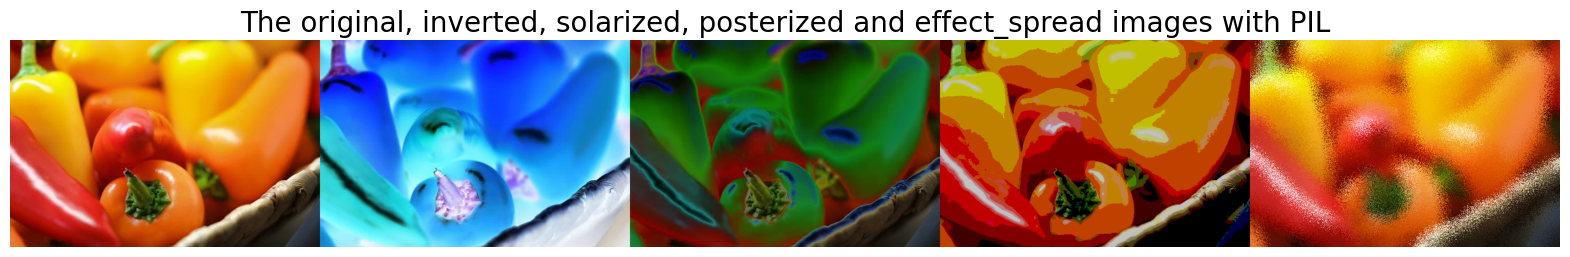

In [126]:
im = Image.open("images/pepper.webp")
im_in, im_sol, im_post = ImageOps.invert(im), ImageOps.solarize(im), ImageOps.posterize(im, 2)
im_out = Image.new('RGB', (5*im.width, im.height))
im_out.paste(im, (0,0))
im_out.paste(im_in, (im.width,0))
im_out.paste(im_sol, (2*im.width,0))
im_out.paste(im_post, (3*im.width,0))
im_out.paste(im.effect_spread(30), (4*im.width,0))
plt.figure(figsize=(20,7))
plt.imshow(im_out), plt.axis('off')
plt.title('The original, inverted, solarized, posterized and effect_spread images with PIL', size=20)
plt.show()

### Converting an image to gray scale

We can use the `convert()` function from `PIL.Image` with parameter `'L'` to change a RGB color image to a grayscale
image as shown in the following code.

In [ ]:
im = Image.open("images/parrot.jpg")
im_g = im.convert('L') 
im_g

You can use the methods `getpixel()` / `putpixel()` too (along with the function `to_gray()`), to convert an RGB to a grasyscale image.

In [ ]:
def to_gray(r, g, b):
    return 0.2989 * r + 0.5870 * g + 0.1140 * b

w, h = im.size

for i in range(w):
    for j in range(h):
        r, g, b = im.getpixel((i, j))
        gr = int(to_gray(r, g, b))
        im.putpixel((i, j), (gr, gr, gr))
    
im

The next figure shows the gray-level image, the output of the above code. We are going to use the grayscale image obtained for the next few gray-level transformations.

### A few gray level point transformations

Here we explore a couple of transformations that transforms each single pixel value from
input image using a function to a corresponding pixel value for the output image, the
function `point()` can be used for this. Each pixel has a value in between 0 to 255, inclusive.

### Log transformation

The log transformation can be used to compress an image that has a dynamic range of pixel
values effectively. The next code uses the point transformation for logarithmic
transformation. As can be seen, the range of pixel values are narrowed, the brighter pixels
from the input image have become darker and the darker pixels have become brighter,
thereby shrinking the range of values of the pixels.

In [89]:
im_g.point(lambda x: 255*np.log(1+x/255)).show()

### Power-law transformation

This transformation is used as γ correction for an image. The next line of code shows how to
use the `point()` function for a power-law transformation with $γ = 0.6$.

In [91]:
im_g.point(lambda x: 255*(x/255)**0.6).show()

### Point transformation on multichannel image

We can use the `point()` function to apply arbitray transformation to each pixel for each of the color channels for an RGB image too, as demonstrated with the next code snippet. 

* First the transfer function $T(r) = rtan(r)$ is applied to the input parrot colro image, it produces highly distorted intensity values across all RGB channels, leading to unnatural and chaotic color shifts. 

* Next, a binary thresholding function is applied separately to each channel, it converts the RGB input image into a posterized high-contrast version, where each color channel is either fully on or fully off, leading to strong color blocking.

* Then color image is first converted to grayscale and then it undergoes a cyclic intensity shift (using the function `np.roll()`), changing brightness levels non-linearly. The `point()` function here accepts a lookup table (LUT) and transform a grayscale image using the LUT. 

* The `ImagingCore.point_transform(scale, offset)` method is used to apply a linear transformation to the image: $I_{out} = \text{scale}. I_{in} + \text{offset}$ (but we need to transform the image mode to `'F'`). It is Useful for contrast adjustment, brightness modification, and inversion. Output values are clamped to stay within the valid range.

Now, refer to the next code snippet.

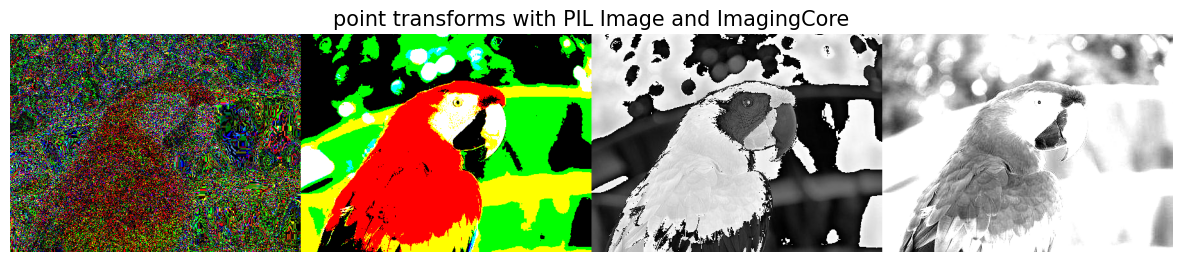

In [76]:
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
im = Image.open('images/parrot.jpg')
im1 = im.point(lambda x: x*np.tan(x))
im2 = im.point(lambda x: 255 if x > 128 else 0)
im3 = im.convert('L').point(np.roll(np.arange(256), 115))
im4 = im.copy()
im4.im = im4.convert('F').getdata().point_transform(3,-100)
im4 = im4.convert('L').convert('RGB')

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((im1, im2, im3.convert('RGB'), im4))), plt.axis('off')
plt.title('point transforms with PIL Image and ImagingCore', size=15)
plt.show()

### A few Geometric Transformations

Geometric image transformations involve manipulating the spatial relationships and orientation of images. These transformations can include rotation, scaling, translation, and other operations that alter the geometry of the image. Scikit-image is a Python library that provides various image processing tools, including functions for geometric transformations. The skimage.transform module in scikit-image is particularly useful for performing these operations.

Here's a brief overview of **Geometric Image Transformations**:

* **Translation**: Shifting the image along the x and y axes.
* **Rotation**: Rotating the image around a specified point.
* **Scaling**: Resizing the image by a specified factor.
* **Shearing**: Distorting the image by changing the angle of different axes.
* **Affine**: Combining translation, rotation, scaling, and shearing.
* **Projective (Homography)**: Generalized transformation for perspective changes.

In this section we shall discuss about a set of geometric transformations that are done by multiplying appropriate matrices (often expressed in homogeneous coordinates) with the image matrix. These transformations change the geometric orientation of an image, hence the name.

### Reflecting an image

We can use the `transpose()` function to reflect an image w.r.t. the horizontal or
the vertical axis. (You can use the `mirror()` function from `PIL.ImageOps` module too)

In [93]:
im.transpose(Image.FLIP_LEFT_RIGHT).show() # reflect about the vertical axis

### Rotating an image

We can use the `rotate()` function to rotate an image by an angle (in degrees).

In [94]:
im_45 = im.rotate(45) # rotate the image by 45 degrees
im_45.show() # show the rotated image

The next figure shows the rotated output images produced by applying reflection and rotation by running the above lines of code.

### Applying an Affine transformation on an image

In [96]:
im = Image.open("images/parrot.png")
im.transform((int(1.4*im.width), im.height), Image.AFFINE, data=(1,-0.5,0,0,1,0)).show() # shear

### Applying Perspective Transformation

Projective traformation (also called perspective transformation in the context of image processing and computer vision) is often used to correct or simulate perspective distortions in images. We can run a perspective transformation on an image with the `transform()` method using `Image.PERSPECTIVE` argument, as shown in the next code block.

In [97]:
params = [1, 0.1, 0, -0.1, 0.5, 0, -0.005, -0.001]
im1 = im.transform((im.width//3, im.height), Image.PERSPECTIVE, params, Image.BICUBIC)
im1.show()

### Changing pixel values of an image

We can use the `putpixel()` function to change a pixel value in an image. Next, let us discuss a
popular application of adding noise to an image using the function.

### Adding salt and pepper noise to an image
We can add some salt-and-pepper noise to an image by selecting a few pixels from the image
randomly and then setting the about half of those pixel values to black and another half to
white. The next code snippet shows how to add the noise.

In [99]:
# choose 5000 random locations inside image
im1 = im.copy() # keep the original image, create a copy
n = 5000
x, y = np.random.randint(0, im.width, n), np.random.randint(0, im.height, n)
for (x,y) in zip(x,y):
    im1.putpixel((x, y), ((0,0,0) if np.random.rand() < 0.5 else (255,255,255))) # salt-and-pepper noise
im1.show()

### Drawing on an image

We can draw lines or other geometric shapes on an image (e.g., the `ellipse()` function to draw
an ellipse) from the `PIL.ImageDraw module`, as shown in the next python code fragment.

In [ ]:
im = Image.open("images/parrot.png")
draw = ImageDraw.Draw(im)
draw.ellipse((125, 125, 200, 250), fill=(255,255,255,128))
del draw
im.show()

### Drawing Bonding Boxes

The method `Image.getbbox()` calculates the smallest bounding box that contains all non-zero (or non-black) pixels in a binary image. The bounding box is returned as a 4-tuple: (`left`, `upper`, `right`, `lower`). If the image has no non-zero pixels, it returns `None`. The next code snippet does the following:
* Loads the grayscale image of a horse.
* Uses the function `getbbox()` to find the bounding box around the horse.
* `ImageDraw.Draw()` creates an object that allows drawing on the image. This draw object will be used to draw a bounding box rectangle.
* Draws a rectangle (using `draw.rectangle()`) on the image using the bounding box. The method accepts the following arguments:
  - `fill=None`: The rectangle is transparent (only an outline is drawn).
  - `outline="red"`: The border of the rectangle is red.
  - `width=3`: The rectangle’s border is 3 pixels thick.
* Deletes draw to free up memory. Not strictly necessary, but a good practice to clean up resources.

Now refer to the next code block.

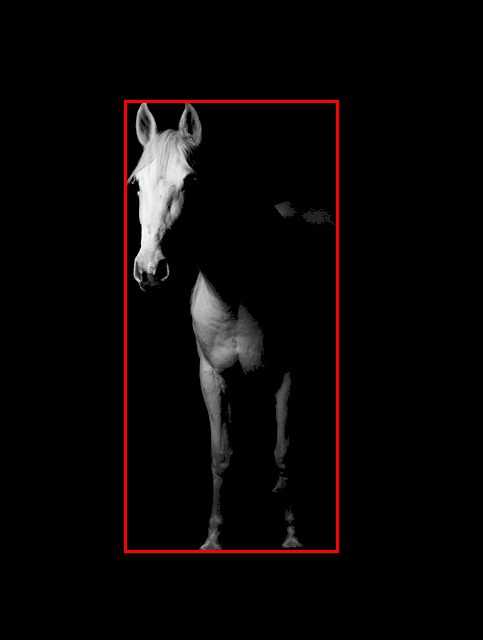

In [127]:
from PIL import ImageDraw
im = Image.open('images/horse.png').convert('L')
im = im.convert('RGB')
draw = ImageDraw.Draw(im)
draw.rectangle(im.getbbox(), fill = None, outline ="red", width = 3) 
del draw
im

### Drawing text on an image

We can draw texts on an image using the `text()` function from `PIL.ImageDraw module`, as
shown in the next python code fragment.

In [101]:
draw = ImageDraw.Draw(im)
font = ImageFont.truetype("arial.ttf", 23) # use a truetype font
draw.text((10, 5), "Welcome to image processing with python", font=font)
del draw
im.show()

### Pasting an image on top of another

We can use the `paste()` function to paste an image on top of another, as shown below. The following figure shows the output image generated by running the code snippet.

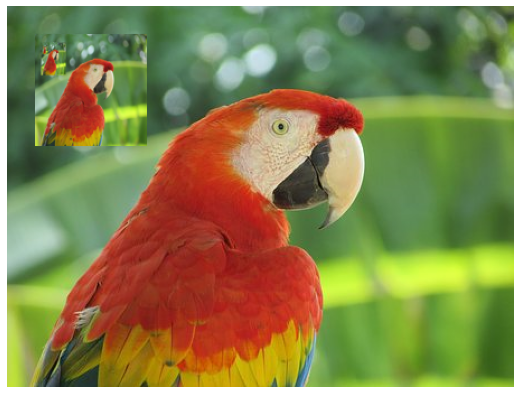

In [107]:
im = Image.open("images/parrot.png")
for i in range(5):
    im_small = im.resize((100,100))
    im.paste(im_small, (25,25))
plt.figure(figsize=(10,7))
plt.imshow(im), plt.axis('off')
plt.show()

### Creating a Thumbnail

We can create the same image as in the last example but this time creating a thumbnail
from the image with the `thumbnail()` function, as shown in the next code block.

In [109]:
im = Image.open("images/parrot.png")
im_thumbnail = im.copy() # need to copy the image first
im_thumbnail.thumbnail((100,100))
im.paste(im_thumbnail, (10,10))
im.show()

### Computing the basic statistics of an image

We can use the stat module to compute the basic statistics (mean, median, standard
deviation of pixel values of different channels etc.) of an image, as shown in the next code
block.

In [111]:
s = stat.Stat(im)
print(s.extrema) # maximum and minumum pixel values for each channel R, G, B
print(s.count)
print(s.mean)
print(s.median)
print(s.stddev)

[(4, 255), (0, 255), (0, 253)]
[154020, 154020, 154020]
[127.62241916634203, 124.89540319439034, 67.81682249058564]
[121, 130, 62]
[47.486354000919064, 52.13537728737721, 39.689444601928486]


### Plotting the histograms of pixel values for the RGB channels of an image

The function `histogram()` can be used to compute the histogram (a table of pixel values vs.
frequencies) of pixels for each channel and returns the concatenated output (e.g., for an
RGB image, the output contains 3 x 256 =768 values). The following figure shows the R,G,B color histograms plotted by running the code snippet.

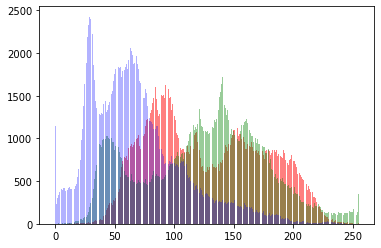

In [112]:
pl = im.histogram()
plt.bar(range(256), pl[:256], color='r', alpha=0.5)
plt.bar(range(256), pl[256:2*256], color='g', alpha=0.4)
plt.bar(range(256), pl[2*256:], color='b', alpha=0.3)
plt.show()

### Separating the RGB channels of an image

We can use the `split()` function to separate the channels of a multi-channel image, as is
shown in the following code for an RGB image.

In [ ]:
ch_r, ch_g, ch_b = im.split() # split the RGB image into 3 channels: R, G and B
# we shall use matplotlib to display the channels
plt.figure(figsize=(18,6))
plt.subplot(1,3,1); plt.imshow(ch_r, cmap=plt.cm.Reds); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(ch_g, cmap=plt.cm.Greens); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(ch_b, cmap=plt.cm.Blues); plt.axis('off')
plt.tight_layout()
plt.show() # show the R, G, B channels

The above figure shows 3 output images created for each of the R,G,B channels
generated by running the above code snippet.

### Combining multiple channels of an image

We can use the `merge()` function to combine the channels of a multi-channel image, as is shown in the
following code, where the color channels obtained by splitting the parrot RGB image is merged after swapping
the red and blue channels.

In [116]:
im = Image.merge('RGB', (ch_b, ch_g, ch_r)) # swap the red and blue channels obtained last time with split()
im.show()

### The alpha (α) channel and blending image

The alpha channel in an image is an additional channel that represents the transparency or opacity of each pixel. It is often used in images with varying levels of transparency, allowing for smooth blending of the image with a background or other images. 

The alpha channel is an integral part of the RGBA color model, where each pixel is represented by four components: Red, Green, Blue, and Alpha. The PNG image format supports alpha channels, making it a popular choice for images that require transparency. JPEG, on the other hand, does not support alpha channels.

The alpha channel allows images to have pixel-level transparency, making it possible to create smooth transitions between the image and a background. 

An alpha value of 0 indicates complete transparency, meaning the pixel is fully see-through. An alpha value of 255 (or 1.0) indicates full opacity, making the pixel fully visible.

### Convert a jpg image to a transparent png image

To convert a JPEG image to a transparent PNG `PIL`, you can follow these steps:

* Open the JPEG image using `Image.open()`.
* Create a new RGBA image using `convert("RGBA")` to add an `alpha` channel.
* Set the alpha channel based on a condition (e.g., transparency threshold based on the RGB values).
* Save the resulting image as a PNG using `Image.save()`.

Now, refer to the next code snippet, which reads a black and white JPG image of birds and saves it as a transparent PNG image.

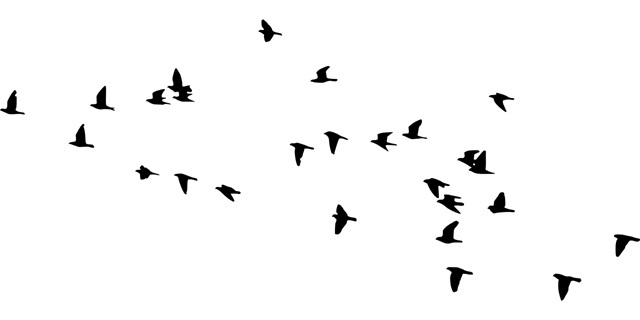

In [139]:
import numpy as np
from PIL import Image, ImageChops

img_trans = Image.new('RGBA', img.size)
alpha = Image.open('images/birds.jpg').convert('L')
img_trans.putalpha(ImageChops.invert(alpha))
img_trans.save('images/bird.png')
img_trans

The next code snippet reads the parrot RGB color JPG image, extracts the regions conrreponding to the red feathers and saves as a trasparent PNG, as shown in the next figure.

In [49]:
import numpy as np
from PIL import Image

img = Image.open('images/parrot.jpg') # n x m x 3
imga = img.convert("RGBA")  # n x m x 4

imga = np.asarray(imga) 
r, g, b, a = np.rollaxis(imga, axis=-1) # split into 4 n x m arrays 
r_m = r > 100 # binary mask for red channel, True for read feathers
g_m = g < 100 # binary mask for green channel, True for read feathers
b_m = b < 200 # binary mask for blue channel, True for read feathers

# combine the three masks using the binary "or" operation 
# multiply the combined binary mask with the alpha channel
a = a * ((r_m == 1) & (g_m == 1) & (b_m == 1))

# stack the img back together 
imga =  Image.fromarray(np.dstack([r, g, b, a]), 'RGBA')
imga.save('images/parrot_transparent.png')

print(img.mode, imga.mode)

RGB RGBA


![](images/parrot_transparent.png)

### α-blending two images

The function `PIL.Image.blend()` can be used to create a new image by interpolating between two given
images (of same size), using a constant α. Both images must have the same size and mode.
The output image is given by $out = image_1. (1.0 - α) + image_2. α$
If α is 0.0, a copy of the first image is returned. If α is 1.0, a copy of the second image is
returned. The next code snippet shows an example.

In [120]:
im1 = Image.open("images/parrot.png")
im2 = Image.open("images/hill.png")
# 453 340 1280 960 RGB RGBA
#im1 = im1.convert('RGBA') # if two images have different modes, must be converted to the same mode
im2 = im2.resize((im1.width, im1.height), Image.BILINEAR) # two images have diffrent sizes, must be converted to the same size
im = Image.blend(im1, im2, alpha=0.5).show()

### α-compositing two images

The method `Image.alpha_composite(a,b)` creates a composite image $a$ over $b$. The equation for alpha value and pixel value of the generated images are:

![](images/alpha_composite.png)

where $\alpha_a$, $\alpha_b$ represent the transparency values and $v_a$, $v_b$ represent the pixel values of the images $a$ and $b$ (RGBA images), respectively. The next code snippet uses this function to obtain a composite of two images, it converts the input RGB images to RGBA image with the method `Image.putalpha()`.

In [ ]:
fish = Image.open('images/fish.png')
sea = Image.open('images/sea.png')
fish.putalpha(100)
sea.putalpha(200)
alpha_comp = Image.alpha_composite(sea, fish)
plt.figure(figsize=(15,5))
plt.imshow(np.hstack((np.array(fish), np.array(sea), np.array(alpha_comp)))), plt.axis('off')
plt.title('alpha composite of the fish and sea images', size=20)
plt.show()

### Adding watermark to an image

A watermark is a recognizable image or pattern that is superimposed onto another image, typically for branding or copyright purposes. Watermarks are often semi-transparent and placed in a corner or across the center of an image to discourage unauthorized use or to identify the creator of the image.

The next code snippet adds *Packt* logo image to the parrot cover image, using the following steps. 

* First both the original input (cover) and watermark images are converted to `RGBA` mode.
* The watermark image is resized and pasted on a blank image, subsequently a semitransparent alpha layer (with $\alpha=128$). 
* Finally, the function `alpha_composite()` is used to combine the alpha channels of the original and the watermark images. The watermarked output produced is shown in the next figure.

In [ ]:
from PIL import Image

cover_image = Image.open('images/parrot.jpg').convert('RGBA')
watermark = Image.open('images/packt.png').resize((100,50)).convert('RGBA')

layer = Image.new('RGBA', cover_image.size, (0, 0, 0, 0))
layer.paste(watermark, (325, 225))

# Create a copy of the layer
layer2 = layer.copy()
# Put alpha on the copy
layer2.putalpha(128)
# merge layers with mask
layer.paste(layer2, layer)

watermarked_image = Image.alpha_composite(cover_image, layer)
watermarked_image.convert('RGB')

### Blending two images with a mask

In [ ]:
from PIL import Image, ImageOps

# Load an image and invert
im = Image.open('images/butterfly.png')
w, h = im.size
im_inv = ImageOps.invert(im)

# Create an intensity gradient mask
grad_mask = np.linspace(0, 1, w)
grad_mask = Image.fromarray((255*np.tile(grad_mask, (h, 1))).astype(np.uint8))

# Composite the image with its inverted version using the gradient mask
im_out = Image.composite(im, im_inv, grad_mask)
print(im.mode, im_inv.mode, grad_mask.mode, im_out.mode)

plt.figure(figsize=(18,12))
plt.gray()
plt.subplot(221), plt.imshow(im), plt.title('original', size=20), plt.axis('off')
plt.subplot(222), plt.imshow(im_inv), plt.title('inverted', size=20), plt.axis('off')
plt.subplot(223), plt.imshow(grad_mask), plt.title('intensity gradient mask', size=20), plt.axis('off')
plt.subplot(224), plt.imshow(im_out), plt.title('composite image', size=20), plt.axis('off')
plt.tight_layout()
plt.show()

Now, use just `numpy` arrays (don't use `PIL` methods) to compute a composite image, this is left as an exercise to the reader (should not need more than three lines of code).

### Adding and differencing two images

The next code snippet shows how an image can be generated by adding two input images (of same size) pixel by pixel using the function `PIL.ImageChops.add()`.

In [126]:
im1 = Image.open("images/parrot.png")
im2 = Image.open("images/hill.png").convert('RGB').resize((im1.width,im1.height))
add(im1, im2).show()

The next line of code uses the function `PIL.ImageChops.difference()` to obtain the absolute value of the pixel-by-pixel difference between the images.

In [128]:
difference(im1, im2).show()

In [ ]:
def diff_numpy(im1, im2): # assumes images have dtype np.uint8, pixel values in between [0,255]
    return np.clip(np.abs(color.rgb2gray(np.array(im1)) - color.rgb2gray(np.array(im2))), 0, 255)

def brighten(im):
    return np.clip((255*im/im.max()).astype(np.uint8) + 50, 0, 255)

im1 = Image.open("images/goal1.png")
im2 = Image.open("images/goal2.png")
#im = screen(im1, im2)
im = difference(im1, im2)
im.save("images/goal_diff.png")

plt.figure(figsize=(15,9))
plt.subplot(221), plt.imshow(im1), plt.axis('off'), plt.title('frame 1', size=20)
plt.subplot(222), plt.imshow(im2), plt.axis('off'), plt.title('frame 2', size=20)
plt.subplot(223), plt.imshow(im), plt.axis('off'), plt.title('difference (PIL)', size=20)
plt.subplot(224), plt.imshow(brighten(diff_numpy(im1, im2)), cmap='gray'), plt.axis('off'), plt.title('difference (numpy)', size=20)
plt.tight_layout()
plt.show()

### Subtracting two images

The next code snippet shows how to first subtract two images, followed by dividing the result by scale
and adding the offset provided as argument to the function `PIL.ImageChops.subtract()`. The scale defaults to 1.0, and offset to 0.0. The following figure shows the output image generated by running the blow code snippet. Note that unlike `difference()`, the two input images can have different size.

In [ ]:
im1 = Image.open("images/parrot.png").convert('RGB')
im2 = Image.open("images/hill.png").convert('RGB')
im = subtract(im1, im2, scale=1.0, offset=0)
print(im1.size, im2.size, im.size)
im.save("images/parrot_hill_subtract.jpg")
#im.show()
plt.figure(figsize=(12,5))
plt.imshow(np.hstack((im, np.array(difference(im, im1))))), plt.axis('off')
plt.title('subtract images and take difference of the output from the first image', size=15)
plt.show()

### Superimposing two images with soft_light, hard_light, overlay algorithms

Let's now demonstrate how to superimpose images using a few algorithms often specified as blending modes. These are mathematical algorithms that dictate how pixels from one image interact with pixels from another image when the two images are combined. These modes control the way pixel values are combined to create a new image. Here are explanations for some common **blending modes** and the output image results obtained using different blending equations:

* **Normal (or Over)**: $\text{result} = \alpha \times \text{foreground} + (1 - \alpha) \times \text{background}$, where α is the transparency value of the foreground pixel, ranging from 0 (completely transparent) to 1 (completely opaque). The resulting pixel is a linear combination of the foreground and background pixels based on their transparency.

* **Hard Light**: 
  $result = \begin{cases}
    2 \times \text{background} \times \text{foreground}, & \text{if foreground } \leq 0.5 \\
    1 - 2 \times (1 - \text{background}) \times (1 - \text{foreground}), & \text{otherwise }
  \end{cases}$
  
This mode simulates shining a harsh spotlight on the image. It produces strong contrast and vivid colors.

* **Soft Light**: $\text{result} = 1 - 2 \times (1 - \text{background}) * (1 - \text{foreground})$

This mode produces a subtle blending of the two images, creating a soft and diffused effect.

* **Overlay**: 
$result = \begin{cases}
    2 \times \text{background} \times \text{foreground}, & \text{if background } \leq 0.5 \\
    1 - 2 \times (1 - \text{background}) \times (1 - \text{foreground}), & \text{otherwise }
  \end{cases}$

This mode enhances the contrast and saturation of the image. It combines the effects of both multiply and screen blending.

These algorithms manipulate pixel values based on the characteristics of the blending mode. The specifics of each algorithm determine how pixels interact, and the choice of blending mode can significantly impact the visual appearance of the resulting image. Keep in mind that these explanations are simplified, and the actual implementations might involve additional considerations for different color channels and color spaces.


### with `PIL`

The functions `hard_light()`, `soft_light()` and `overlay()` from the module `PIL.ImageChops`can be used to superimpose two images using the above algorithms, as demonstrated in the next code snippet and the outputs obtained are shown in the next figure.

In [ ]:
im1 = Image.open("images/scene.jpg")
im2 = Image.open("images/turtle.jpg").convert('RGB').resize((im1.width, im1.height))
im_hard = hard_light(im1, im2)
im_soft = soft_light(im1, im2)
im_overlay = overlay(im1, im2)
plt.figure(figsize=(20,7))
plt.imshow(np.hstack((im_hard, im_soft, im_overlay))), plt.axis('off')
plt.title('blending with hard-light, soft-light and overlay algorithms', size=20)
plt.show()

### with `blend-mode`

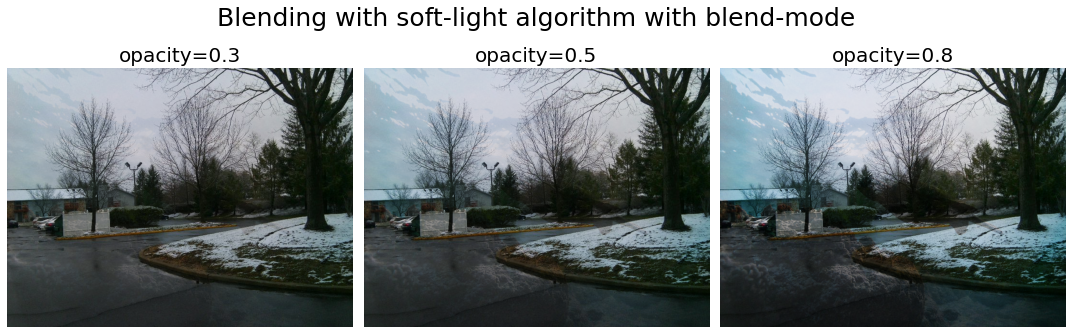

In [82]:
#opacity = 0.7  # The opacity of the foreground that is blended onto the background is 70 %.
plt.figure(figsize=(15,5))
i = 1
for opacity in [0.3, 0.5, 0.8]:
    blended_img_float = blend_modes.soft_light(imgviz.rgb2rgba(np.array(im1)).astype(float), 
                               imgviz.rgb2rgba(np.array(im2)).astype(float), opacity)
    plt.subplot(1,3,i), plt.imshow(np.uint8(blended_img_float)), plt.axis('off'), plt.title(f'opacity={opacity}', size=20)
    i += 1
plt.suptitle('Blending with soft-light algorithm with blend-mode', size=25)
plt.tight_layout()
plt.show()

In [132]:
im1 = Image.open("images/parrot.png")
im2 = Image.open("images/hill.png").convert('RGB').resize((im1.width, im1.height))
screen(im1, im2).show()

### Getting darker / lighter of two images

Compares the two images, pixel by pixel, and returns a new image containing the lighter values, using the function `PIL.ImageChops.lighter()`.

In [194]:
im1 = Image.open("images/parrot.png")
im2 = Image.open("images/hill.png").convert('RGB').resize((im1.width, im1.height))
lighter(im1, im2).show()